### Compare louvain with subreddit communities
We build a set of communities by subreddit. A person is assigned to the subreddit communities where he post the most frequently.

In [214]:
import pandas as pd
import networkx as nx
from collections import Counter

df_edges_brut = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')
df_source = df_edges_brut[["source", "sub"]]
df_target = df_edges_brut[["target", "sub"]]

# Concat source and target df
df = pd.concat([df_source, df_target.rename(columns={"target": "source"})])

# Keep rows with the most frequent sub
df = df.groupby("source").sub.agg(lambda x: Counter(x).most_common(1)[0][0]).reset_index()

# Convert to dict
communities_dict = df.set_index('source').T.to_dict('records')[0]

# Convert dict to list of set
unique_coms = {v: i for i, v in enumerate(set(communities_dict.values()))}
communities = [set() for _ in range(len(unique_coms))]
for v, k in communities_dict.items():
   communities[unique_coms[k]].add(v)

Then run louvain method on the graph to find partitions:

In [215]:
import networkx.algorithms.community as nx_comm

# Load graph
df_edges = pd.read_csv('../data/edgelist.csv')
G = nx.from_pandas_edgelist(df_edges)

# Compute partitions with louvain
partitions = nx_comm.louvain_communities(G, seed=123)

Compare people in the two sets:

In [250]:
a = set()
for community in communities:
   a = a | community

b = set()
for community in partitions:
   b = b | community

print(f"Number of person in set: A - {len(a)} B - {len(b)}")
print(f"Intersection between the two sets: {len(a.intersection(b))}")
print(f"Number of Louvain communities: {len(partitions)}")
print(f"Number of subreddit: {len(communities)}")

Number of person in set: A - 25723 B - 15496
Intersection between the two sets: 15481
Number of Louvain communities: 242
Number of subreddit: 10


Compare the 2 lists of sets:

In [226]:
# Get set intersection between louvain and subreddit communities
intersections = []
for p in partitions:
   intersections.append([len(p.intersection(c)) / len(p) for c in communities])

# Print matrix
for inter in intersections:
   print(['%.2f' % v for v in inter])

['0.00', '0.00', '0.10', '0.90', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.01', '0.82', '0.01', '0.00', '0.00', '0.00', '0.02', '0.14', '0.01']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.02', '0.02', '0.16', '0.00', '0.00', '0.00', '0.01', '0.75', '0.02', '0.01']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
['0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.

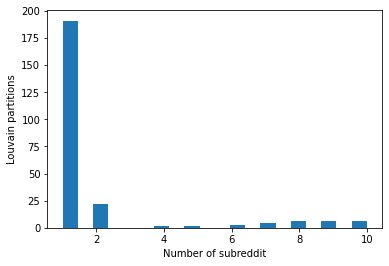

In [247]:
from matplotlib import pyplot as plt

repartition = [sum(1 if v else 0 for v in inter) for inter in intersections]

plt.hist(repartition, bins=20)
plt.ylabel("Louvain partitions")
plt.xlabel("Number of subreddit")
plt.savefig('../data/images/inner_communities_repartition.pdf')
plt.show()

### Observation

Louvain method is a technique that find communities from large networks. In our case, we can see that there is 242 communities found with Louvain method in only 10 subreddit. These communities are not all restricted to one subreddit. Some are interacting in several subreddit but this is not the case for the majority.